# NYC TAXI and LIMOUSINE TRIP ANALYSIS 

## By Jagpreet Singh Sethi

#### Dataset Source: Public NYC Taxi and Limousine trip record data for Sept 2015

In [1]:
# Following are the necessary set of libraries

import pandas as pd
import urllib
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import metrics
from sklearn import linear_model
pd.set_option("display.max_columns", 40)

In [2]:
%matplotlib inline

### Question 1: 
Part 1: Programmatically download and load into your favorite analytical tool the trip data for September 2015.

In [3]:
def download_data(url,output):
    datafile = urllib.URLopener()
    datafile.retrieve(url,output)

url = "https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv"
output = "nyc_green_sept.csv"

download_data(url,output)

In [4]:
data = pd.read_csv("nyc_green_sept.csv")

Part 2: Report how many rows and columns of data you have loaded.

In [5]:
print "NYC Green Taxi - Sep'15 Dataset contains {} rows and {} columns".format(len(data),len(data.columns))

NYC Green Taxi - Sep'15 Dataset contains 1494926 rows and 21 columns


## Question 2:
Plot a histogram of the number of the trip distance ("Trip Distance").<br>
Report any structure you find and any hypotheses you have about that structure.

In [6]:
data['Trip_distance'].describe()

count    1.494926e+06
mean     2.968141e+00
std      3.076621e+00
min      0.000000e+00
25%      1.100000e+00
50%      1.980000e+00
75%      3.740000e+00
max      6.031000e+02
Name: Trip_distance, dtype: float64

We observe that:
Minimum distance = 0 miles, Max Distance = 603 Miles, Average Distance = 2.96 Miles, 3rd Quartile = 3.74 Miles


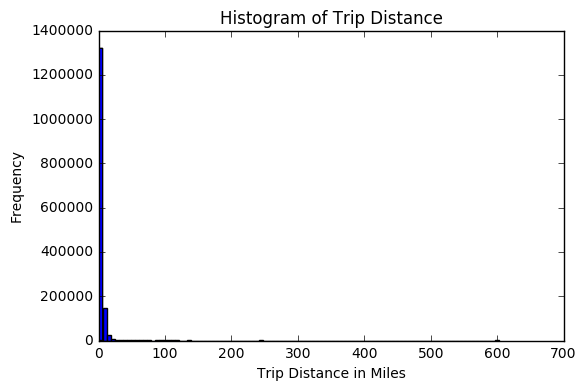

In [7]:
plt.hist(data['Trip_distance'],bins=100)
plt.xlabel("Trip Distance in Miles")
plt.ylabel("Frequency")
plt.title("Histogram of Trip Distance")

##### Interpretation: 
Histogram of Trip Distance feature is highly right skewed.
This gives us an understanding that there are few records whose trip distances are exceptionaly high.
Therefore, there is good likeliness that these records could be outlier or incorrect enteries.
So, we should develop a strategy to remove such records as these will affect histogram range.

#### To identify incorrect enteries that could affect the Trip Distance field we'll be consider few cases

<b>Case 1:</b> As per the NYC road limits and the fact that NYC Green Taxi operate in city, it would be safe to assume that they won't exceed 40 miles per hour or 0.011 miles per second. Using this fact, we'll create a new field <b>'Speed'</b> and filter records that have MilesPerSecond less than 0.011.

In [8]:
max_speed = 0.011

Column lpep_dropoff_datetime and lpep_pickup_datetime is in string format, so converting it to datetime format.<br>
Column Trip_distance is in string format, so converting it to numeric format.

In [9]:
data['Lpep_dropoff_datetime']=pd.to_datetime(data['Lpep_dropoff_datetime'])
data['lpep_pickup_datetime']=pd.to_datetime(data['lpep_pickup_datetime'])
data['Trip_distance']=pd.to_numeric(data['Trip_distance'])

Dataset has DropOff Time and PickUp Time. On subtracting these two fields, we get Trip Time.

In [10]:
data['Trip_Time']=data['Lpep_dropoff_datetime']-data['lpep_pickup_datetime']
data['Trip_Time']=data['Trip_Time'].astype('timedelta64[s]')
data['Speed']=data['Trip_distance']/data['Trip_Time']

In [11]:
data['Speed'].isnull().value_counts()

False    1493989
True         937
Name: Speed, dtype: int64

<b>Case 2:</b> Any record with Trip Time equal to 0 are likely to be incorrect because customers won't pay if they haven't book a ride. <br>

There are 937 Null values in the field 'Speed'. This is because division of Trip_distance by Trip_Time being 0 is not defined. Therefore, we can remove such cases.

<b>Case 3:</b> It is always the customer who pays to the driver for the ride service provided. Therefore, Total_amount should always be greater than zero. We shall remove all records where total_amount is negative. 

In [12]:
data_filtered = data[(data['Speed'] <= max_speed) & (data['Trip_Time'] > 0.0) & (data['Total_amount']>=0)].copy()

In [13]:
print "Number of outlier in the dataset are {}".format(len(data) - len(data_filtered))
PercentOutliers = round(float(len(data) - len(data_filtered))/len(data)*100,3)
print "Percentage of Outliers in the dataset for Trip Distance: {} %".format(PercentOutliers)

Number of outlier in the dataset are 10651
Percentage of Outliers in the dataset for Trip Distance: 0.712 %


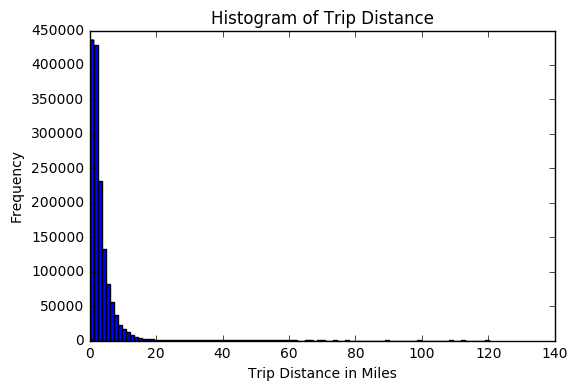

In [14]:
plt.hist(data_filtered['Trip_distance'],bins=100)
plt.xlabel("Trip Distance in Miles")
plt.ylabel("Frequency")
plt.title("Histogram of Trip Distance")

Above histogram is what we should consider for understanding distribution of Trip Distances in Miles

Let's zoom the area by limiting the x-axis range to 20 to understand better the distribution of most frequent Trip Distances.

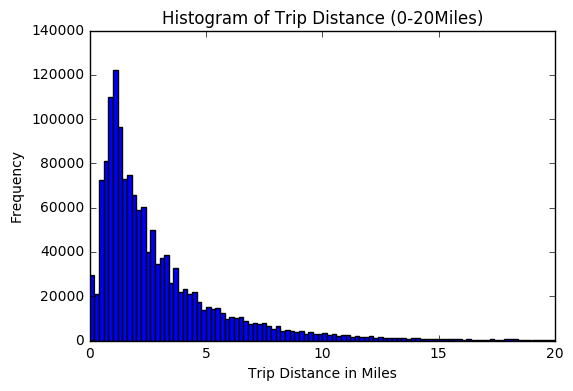

In [15]:
plt.hist(data_filtered['Trip_distance'],bins=100, range=(0,20))
plt.xlabel("Trip Distance in Miles")
plt.ylabel("Frequency")
plt.title("Histogram of Trip Distance (0-20Miles)")

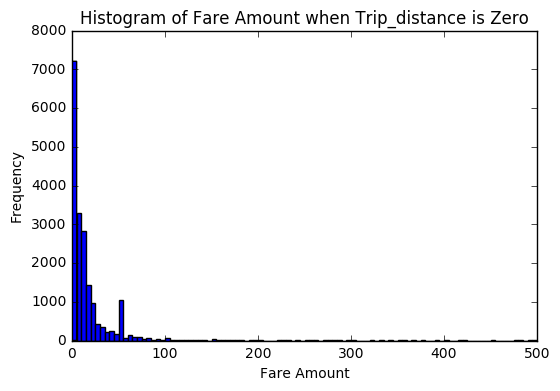

In [16]:
plt.hist(data_filtered[data_filtered['Trip_distance']==0]['Total_amount'],bins=100)
plt.xlabel("Fare Amount")
plt.ylabel("Frequency")
plt.title("Histogram of Fare Amount when Trip_distance is Zero")

<b>Case 4:</b> As observed in the histogram, there are few cases where Trip_distance and Fare_Amount is zero. These are again incorrect entries and should be ideally removed.

In [17]:
index1 = data_filtered[(data_filtered['Trip_distance']==0) & (data_filtered['Total_amount']==0)].index
data_filtered = data_filtered[~data_filtered.index.isin(index1)]

In [18]:
print "Number of outlier in the dataset are {}".format(len(data) - len(data_filtered))
PercentOutliers = round(float(len(data) - len(data_filtered))/len(data)*100,3)
print "Percentage of Outliers in the dataset for Trip Distance: {} %".format(PercentOutliers)

Number of outlier in the dataset are 11237
Percentage of Outliers in the dataset for Trip Distance: 0.752 %


##### Interpretation:
1) There are rides when NYC Green Taxi was used to travel as long as 140 Miles. <br>
2) Most of the trip rides were short distanced between 1 mile to 4 miles i.e. from one place to another within city. <br>
3) From the Fare Amount histogram, we get an understanding that despite the fact Trip_distance is equal to Zero, customers were charged reasonable fare amount. These could be the cases when Green Taxi was pre-booked and customers made them wait for long time or cancelled it later which caused them booking charges.

# Question 3

#### Part A: Report mean and median trip distance grouped by hour of day.

Lpep_dropff_datetime and lpep_pickup_datetime columns are of Datetime type format and hence, we can easily extract hour values from it.

In [19]:
data_filtered['DropOff_hour'] = data_filtered['Lpep_dropoff_datetime'].apply(lambda x: x.hour)
data_filtered['PickUp_hour'] = data_filtered['lpep_pickup_datetime'].apply(lambda x: x.hour)

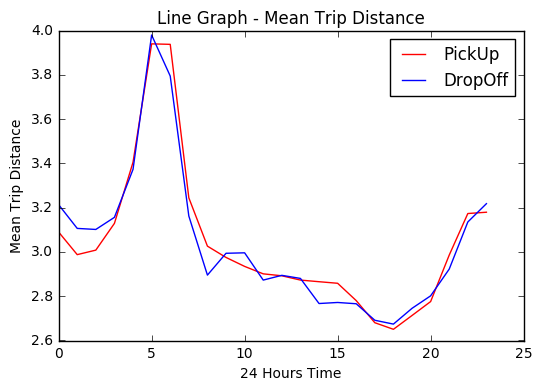

In [20]:
pick_mean_td_hourly = data_filtered.groupby('PickUp_hour').mean().Trip_distance
drop_mean_td_hourly = data_filtered.groupby('DropOff_hour').mean().Trip_distance
plt.plot(pick_mean_td_hourly,'r', label = 'PickUp')
plt.plot(drop_mean_td_hourly,'b', label = 'DropOff')
plt.xlabel("24 Hours Time")
plt.ylabel("Mean Trip Distance")
plt.title("Line Graph - Mean Trip Distance")
plt.legend()
plt.show()

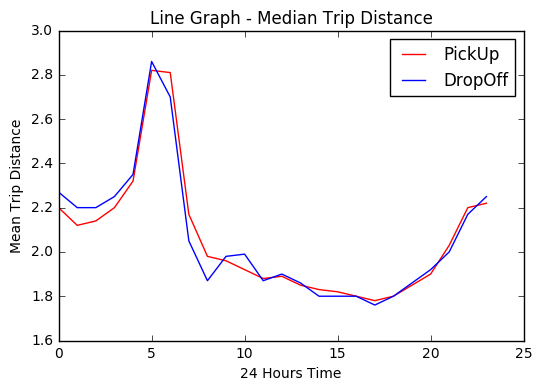

In [21]:
pick_median_td_hourly = data_filtered.groupby('PickUp_hour').median().Trip_distance
drop_median_td_hourly = data_filtered.groupby('DropOff_hour').median().Trip_distance
plt.plot(pick_median_td_hourly,'r', label = 'PickUp')
plt.plot(drop_median_td_hourly,'b', label = 'DropOff')
plt.xlabel("24 Hours Time")
plt.ylabel("Mean Trip Distance")
plt.title("Line Graph - Median Trip Distance")
plt.legend()
plt.show()

##### Interpretation:

1) Maximum distance travelled by commuters is between 4 AM to 7 AM. Such commuters most likely stay at the outskirts of NYC and use Green Taxi to reach nearest public transportation so that they can reach their work place.<br>
2) During office hours like 10 AM to 4 PM, people are at their work place which is often in an area with lot of restaurants and shopping malls. So, incase someone hires Green taxi during these hours they are likely to hire it for short distances as almost everything would be in their vicinity.<br>
3) In the evening at around 5PM, people like to travel back to their home which is at an considerable distance from work place.

Note: Mean metric is very sensitive to outliers and hence, we see mean trip distance at 5AM to be higher than median trip distance at 5AM. Here, for our analysis we are using MEDIAN as a metric for analysis as it is robust to outliers.

### Part B: We'd like to get a rough sense of identifying trips that originate or terminate at one of the NYC area airports. Can you provide a count of how many transactions fit this criteria, the average fair, and any other interesting characteristics of these trips.

<img src=http://www.nyc.gov/html/tlc/images/features/map_service_area.png width="500" height="200" /img >

There are two prominent airports in the area of New York: <br>
1) JFK Airport (JFK) <br>
2) LaGuardia Airport (LGA) <br>

Newark Airport is considered to be in New Jersey, So I am excluding that out.

NYC Green Taxi Dataset's variable description is provided in the document:  http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf. <br> According to this document, JFK Airport is labeled as 1 in <b>RateCodeID</b> column. <br>

However, no information is provided for the other airport i.e. LaGuardia Airport. <br>

To figure out if there was a dropoff to or pickup from LaGuardia Airport, we'll be measuring distance between LaGuardia Airport's geospatial coordinates (Lattitude: 40.771765, Longitude: -73.872434) and dropoff or pickup coordinates. 
To measure this distance we are using 'Great-Circle distance' calculated using Haversine formula.
<br>

##### Objective: If the above measured distance is less than walkable distance of 0.5 mile. We can assume that pickup of dropoff was at the airport.

In [22]:
from math import sin, cos, radians, sqrt, atan2
def miles_calculate(lat1,lon1,lat2,lon2):
    """
    Implemented ‘haversine’ formula to calculate the great-circle distance between two points.
    That is, the shortest distance over the earth’s surface.
    Reference: http://www.movable-type.co.uk/scripts/latlong.html
    """
    R = 6373.0

    lat1 = radians(lat1)
    long1 = radians(lon1)
    lat2 = radians(lat2)
    long2 = radians(lon2)

    diff_long = long2 - long1
    diff_lat = lat2 - lat1
    
    a = sin(diff_lat / 2)**2 + cos(lat1) * cos(lat2) * sin(diff_long / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c / 1.609344

    return distance

In [23]:
data_filtered['LaGuadia_Pickup_Distance']=data_filtered.apply(lambda x:  miles_calculate(40.771765, -73.872434,x['Pickup_latitude'], x['Pickup_longitude']), axis=1)
data_filtered['LaGuadia_DropOff_Distance']=data_filtered.apply(lambda x:  miles_calculate(40.771765, -73.872434,x['Dropoff_latitude'], x['Dropoff_longitude']), axis=1)

In [24]:
data_filtered['JFK_Pickup_Distance']=data_filtered.apply(lambda x:  miles_calculate(40.645506, -73.785918,x['Pickup_latitude'], x['Pickup_longitude']), axis=1)
data_filtered['JFK_DropOff_Distance']=data_filtered.apply(lambda x:  miles_calculate(40.645506, -73.785918,x['Dropoff_latitude'], x['Dropoff_longitude']), axis=1)

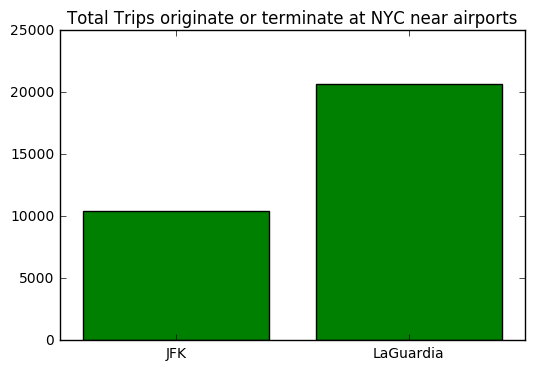

In [25]:
labels = ["JFK", "LaGuardia"]

count_of_JFK=len(data_filtered[data_filtered['JFK_DropOff_Distance'] < 0.5]) + \
             len(data_filtered[data_filtered['JFK_Pickup_Distance'] < 0.5])
count_of_laguadia = len(data_filtered[data_filtered['LaGuadia_DropOff_Distance'] < 0.5]) + \
                    len(data_filtered[data_filtered['LaGuadia_Pickup_Distance'] < 0.5])
   
data = [count_of_JFK, count_of_laguadia]

xlocations = np.array(range(len(data))) + 1
plt.bar(xlocations,data, tick_label=labels, align='center', color = 'green')
plt.title("Total Trips originate or terminate at NYC near airports")

##### Interpretation
1) The count of originate or terminate trips for LaGaurdia airport is much higher than JFK airport. <br>
2) NYC Green taxi is not used at all to reach LongIsland airport as it is not in operational range of Green Taxi's

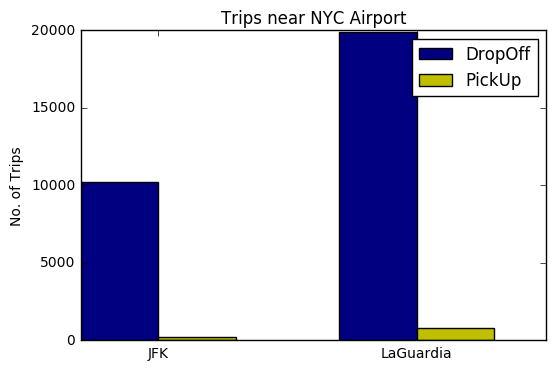

In [26]:
labels = ["JFK", "LaGuardia"]

drop_count_of_JFK = len(data_filtered[data_filtered['JFK_DropOff_Distance'] < 0.5])         
drop_count_of_laguadia = len(data_filtered[data_filtered['LaGuadia_DropOff_Distance'] < 0.5])

pick_count_of_JFK = len(data_filtered[data_filtered['JFK_Pickup_Distance'] < 0.5])         
pick_count_of_laguadia = len(data_filtered[data_filtered['LaGuadia_Pickup_Distance'] < 0.5])

data1 =   [drop_count_of_JFK, drop_count_of_laguadia]
data2 =   [pick_count_of_JFK, pick_count_of_laguadia]

xlocations = np.array(range(len(data1))) 
width = 0.3
fig, ax = plt.subplots()
chart1 = ax.bar(xlocations, data1 , width, color='navy')
chart2 = ax.bar(xlocations + width, data2, width, color='y')
ax.set_ylabel('No. of Trips')
ax.set_title('Trips near NYC Airport')
ax.set_xticks(xlocations + width)
ax.set_xticklabels(("JFK", "LaGuardia", "LongIsland"))
ax.legend((chart1[0], chart2[0]), ('DropOff', 'PickUp'))
plt.show()

##### Interpretation
DropOffs are much higher than PickUps for JFK and LaGuardia airports. <br> This is because as per the NYC Laws, Green Taxi are not allowed to operate in Airport areas and hence, they cannot give ride to the passenger hailing near these streets. Customers need to pre-book it if they want a ride from Airport. However, Green Taxi can drop passengers who has hailed on one of boroughs to the Airport. That's why we see significant number of DropOff as compared to PickUp.

Reference Link: http://www.nyc.gov/html/tlc/html/passenger/shl_passenger.shtml

In [27]:
print "JFK AIRPORT:"
print "Number of DropOff at JFK Airport is {}".format(len(data_filtered[data_filtered['JFK_DropOff_Distance'] < 0.5]))
print "Number of PickOff at JFK Airport is {}".format(len(data_filtered[data_filtered['JFK_Pickup_Distance'] < 0.5]))
print "Total Number of trips that originate or terminate at JFK Airport is {} \n".format(count_of_JFK)

print "LAGUARDIA AIRPORT:"
print "Number of DropOff at LaGuardia Airport is {}".format(len(data_filtered[data_filtered['LaGuadia_DropOff_Distance'] < 0.5]))
print "Number of PickOff at LaGuardia Airport is {}".format(len(data_filtered[data_filtered['LaGuadia_Pickup_Distance'] < 0.5]))
print "Total Number of trips that originate or terminate at LaGuardia Airport is {} \n".format(count_of_laguadia)



JFK AIRPORT:
Number of DropOff at JFK Airport is 10225
Number of PickOff at JFK Airport is 235
Total Number of trips that originate or terminate at JFK Airport is 10460 

LAGUARDIA AIRPORT:
Number of DropOff at LaGuardia Airport is 19889
Number of PickOff at LaGuardia Airport is 799
Total Number of trips that originate or terminate at LaGuardia Airport is 20688 



In [28]:
laguardia_trips = data_filtered[(data_filtered['LaGuadia_DropOff_Distance'] < 0.5) | (data_filtered['LaGuadia_Pickup_Distance'] < 0.5)]
jfk_trips = data_filtered[(data_filtered['JFK_DropOff_Distance'] < 0.5) | (data_filtered['JFK_Pickup_Distance'] < 0.5)]

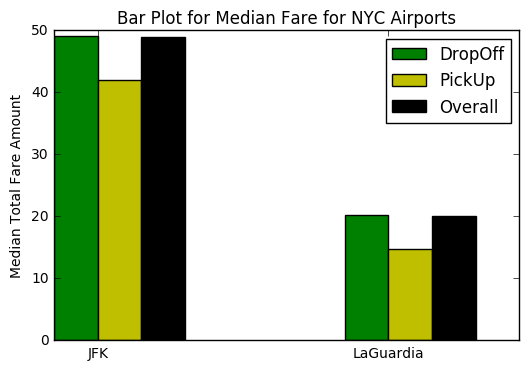

In [29]:
drop_JFK = data_filtered[data_filtered['JFK_DropOff_Distance'] < 0.5]['Total_amount'].median()         
drop_laguadia = data_filtered[data_filtered['LaGuadia_DropOff_Distance'] < 0.5]['Total_amount'].median()

pick_JFK = data_filtered[data_filtered['JFK_Pickup_Distance'] < 0.5]['Total_amount'].median()         
pick_laguadia = data_filtered[data_filtered['LaGuadia_Pickup_Distance'] < 0.5]['Total_amount'].median()

laguardia = laguardia_trips['Total_amount'].median()
jfk = jfk_trips['Total_amount'].median()

data1 =   [drop_JFK, drop_laguadia]
data2 =   [pick_JFK, pick_laguadia]
data3 =   [jfk     , laguardia]

xlocations = np.array(range(len(data2)))
width = 0.15
fig, ax = plt.subplots()
chart1 = ax.bar(xlocations, data1 , width, color='green')
chart2 = ax.bar(xlocations + width, data2, width, color='y')
chart3 = ax.bar(xlocations + width + width, data3, width, color='black')
ax.set_ylabel('Median Total Fare Amount')
ax.set_title('Bar Plot for Median Fare for NYC Airports')
ax.set_xticks(xlocations + width )
ax.set_xticklabels(("JFK", "LaGuardia"))
ax.legend((chart1[0], chart2[0], chart3[0]), ('DropOff', 'PickUp', 'Overall'))
plt.show()

##### Interpretation: 
Median total fare amount for DropOff or PickUp trips to JFK Airport is roughly double as compared to Laguardia airport.

### Interesting Question: Now let's see at what time maximum number of people transit from these airports

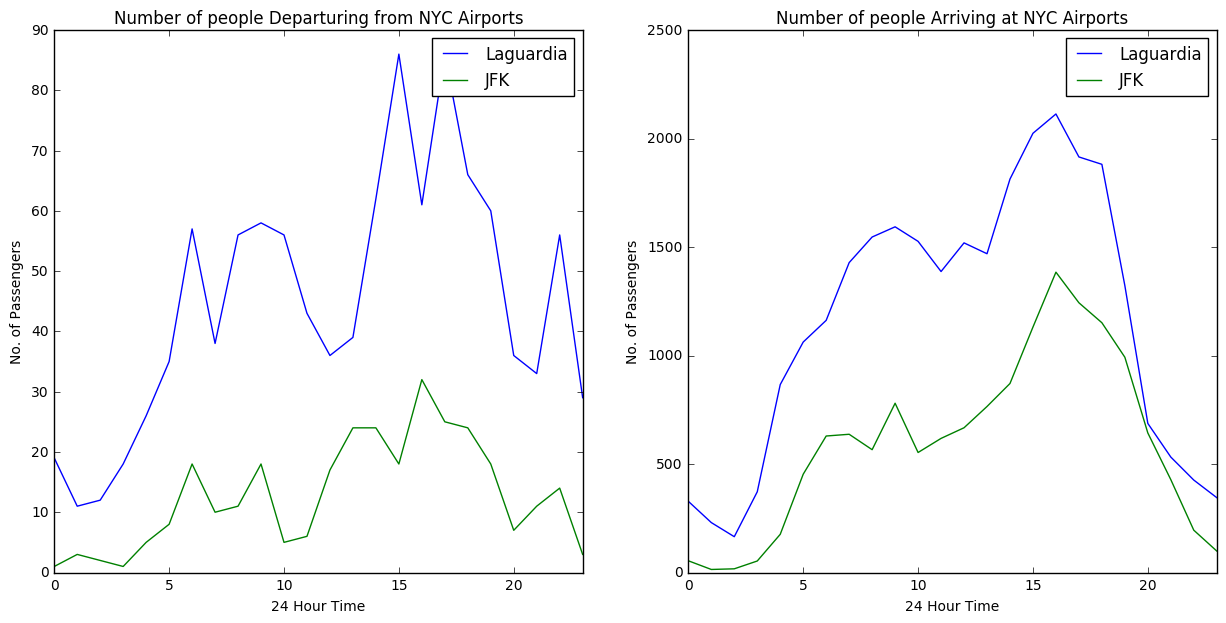

In [37]:
fig, axs = plt.subplots(1,2, figsize=(15,7))
fig.subplots_adjust(hspace=20)
laguardia_pick = data_filtered[(data_filtered['LaGuadia_Pickup_Distance'] < 0.5)]
jfk_pick = data_filtered[(data_filtered['JFK_Pickup_Distance'] < 0.5)]
laguardia_pick.groupby('PickUp_hour').sum()['Passenger_count'].plot(label = 'Laguardia',ax=axs[0])
jfk_pick.groupby('PickUp_hour').sum()['Passenger_count'].plot(label = 'JFK', ax=axs[0])
axs[0].set_title("Number of people Departuring from NYC Airports")
axs[0].set_xlabel("24 Hour Time")
axs[0].set_ylabel("No. of Passengers")
axs[0].legend()

laguardia_drop = data_filtered[(data_filtered['LaGuadia_DropOff_Distance'] < 0.5)]
jfk_drop = data_filtered[(data_filtered['JFK_DropOff_Distance'] < 0.5)]
laguardia_drop.groupby('DropOff_hour').sum()['Passenger_count'].plot(label = 'Laguardia',ax=axs[1])
jfk_drop.groupby('DropOff_hour').sum()['Passenger_count'].plot(label = 'JFK',ax=axs[1])
axs[1].set_title("Number of people Arriving at NYC Airports")
axs[1].set_xlabel("24 Hour Time")
axs[1].set_ylabel("No. of Passengers")
axs[1].legend()



##### Interpretation:

* Both the Arrival and Departure graph show sudden surge in number of people during afternoon hours <br>
* Later in the evening, their demand drastically decreases. This could is because they receive lot of hails from street passengers and don't prefer airport pre-bookups any more. This fact is well justified from the graph previous built up.

### Interesting Question: Let's see what is the most preferred mode of payment by customer

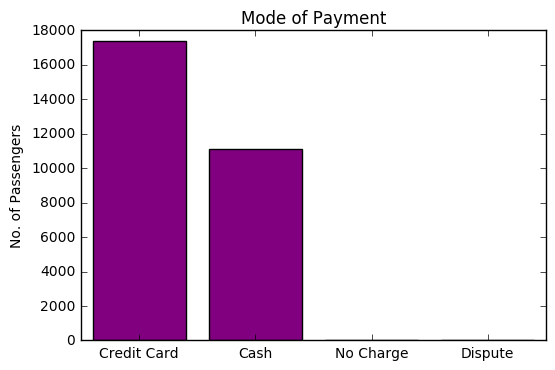

In [31]:
labels = ["Credit Card", "Cash", "No Charge", "Dispute"]
payment_type = laguardia_trips.groupby('Payment_type').sum()['Passenger_count']
xlocations = np.array(range(len(payment_type)))
plt.bar(xlocations,laguardia_trips.groupby('Payment_type').sum()['Passenger_count'], tick_label=labels, align='center', color='purple')
plt.ylabel("No. of Passengers")
plt.title("Mode of Payment")

###### Interpretation: 
* Significantly good number of people use credit card to make the payment and this is very true as plastic money is preferred over paper money.

* 54% more customers prefer Credit card over cash payments


In [32]:
data_filtered['Day_of_Week']=pd.to_datetime(data_filtered['lpep_pickup_datetime']).dt.dayofweek

In [38]:
def isWeekend(x):
    if x == 5 or x == 6:
        return 1
    else:
        return 0
    
data_filtered['isWeekend'] = data_filtered.apply(lambda x: isWeekend(x['Day_of_Week']), axis=1)

### Interesting Question: Let's analyze the effect of Weekend and Weekday on <br>
<b> 1) Number of passengers planning to commute via Green Taxi <br>
2) Distance travelled during Weekdays vs Weekends <br>
3) Speed of the Green Taxi on Weekends vs Weekdays </b>

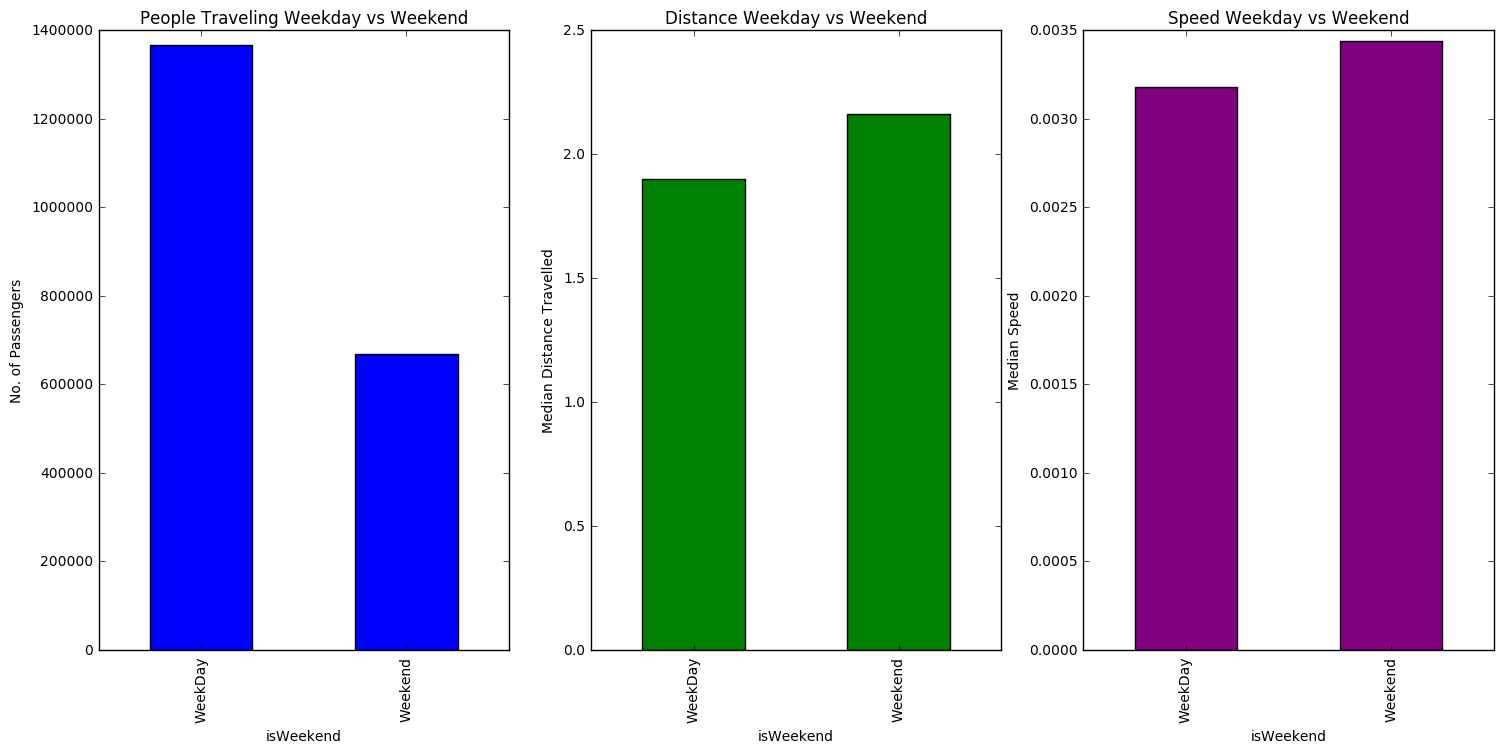

In [39]:
labels = ['WeekDay','Weekend']
fig, axs = plt.subplots(1,3, figsize=(18,8))
fig.subplots_adjust(hspace=20)
data_filtered.groupby('isWeekend').sum()['Passenger_count'].plot(kind='bar',ax=axs[0])
axs[0].set_title("People Traveling Weekday vs Weekend")
axs[0].set_xticklabels(labels)
axs[0].set_ylabel("No. of Passengers")

data_filtered.groupby('isWeekend').median()['Trip_distance'].plot(kind='bar',ax=axs[1], color='green')
axs[1].set_title("Distance Weekday vs Weekend")
axs[1].set_xticklabels(labels)
axs[1].set_ylabel("Median Distance Travelled")

data_filtered.groupby('isWeekend').median()['Speed'].plot(kind='bar',ax=axs[2], color='purple')
axs[2].set_title("Speed Weekday vs Weekend")
axs[2].set_xticklabels(labels)
axs[2].set_ylabel("Median Speed")

##### Interpretation: 
1) Lot more number of people travel travel on Weekdays than on weekend. This is because lot of people hail Green Taxi's to reach their work place and relax at their home on weekends. <br>
2) On Weekends, median distances are more. Probably becauase passengers travel inter-borough or go out for outing some miles away. <br>
3) As the streets are less crowded, Taxi drivers are able to drive at relatively higher speed on weekends.

# Question 4
<b>
* Build a derived variable for tip as a percentage of the total fare. <br>
* Build a predictive model for tip as a percentage of the total fare. Use as much of the data as you like (or all of it). We will validate a sample. </b>

I am creating a new variable named 'Tip_Percent' which signifies tip as a percentage of the total fare. Example: 20 in the Tip_Percent would mean 20% of the Total_amount say 100 was paid as a tip which comes out to be 20 Dollars.

In [40]:
data_filtered['Tip_Percent'] = data_filtered['Tip_amount']*100/data_filtered['Total_amount']

#### PREDICTIVE MODELING:

Model Building process involves following critical steps:
* Data Cleaning
* Exploratory Data Analysis
* Model Selection
* Model Fitting
* Model Evaluation

We are asked to build a model to predict the Tip as a percentage of the total fare. Therefore, <br>
* Response or dependent variable is <b> Tip_Percent </b> <br>
* Predictors would be all the other features.

As Tip_Percent variable is created from Tip_amount and Total_amount, there is very high correlation between two. <br>
We should remove either of these to make the model practical.
<br>
In our case, we'll be removing Tip_amount from the dataframe.


#### Data Cleaning Phase:

In [41]:
data_filtered[data_filtered['Tip_Percent'].isnull()]['RateCodeID'].value_counts()

5    3244
1      81
2       9
3       2
4       2
Name: RateCodeID, dtype: int64

#### Note: <br>
* Column Ehail_Fee has all empty records. Also, there is no information about this column in the variable description document provided by the NYC.gov (http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf). So, we'll be removing this variable from dataset.

* On analysing further we see that 3338 records are NaN in the response variable field 'Tip_Percent'. This is because 'Total_amount' was zero for these records and anything divided by zero is not defined. As a result Tip_Percent column shows us NaN for those records.

* On analyzing the Tip_Percent and its Null values, we find that 97% of the records have RateCodeID as 5, which signifies UNKNOWN as per the document provided by NYC.gov

* Also, there are 4 records missing in Trip_type field.

Considering all the above points, It would be save to assume that these records are incorrect records and can be removed from the dataset.



In [42]:
newdata = data_filtered[~data_filtered['Tip_Percent'].isnull()]
newdata = newdata[~newdata.iloc[:,20].isnull()]
del newdata['Ehail_fee']

Lot of predictor variables are not in the right format the way it should be. <br>
So, converting their data type as per business logic.

In [43]:
cols = ['VendorID', 'RateCodeID', 'Payment_type', 'Day_of_Week', 'isWeekend','Store_and_fwd_flag' ]

for col in cols:
    newdata[col] = newdata[col].astype('category')
newdata.iloc[:,19] = newdata.iloc[:,19].astype('category')


Now the dataset has no missing values and has proper variable data types. It is ready to perform further analysis

#### EXPLORATORY DATA ANALYSIS:

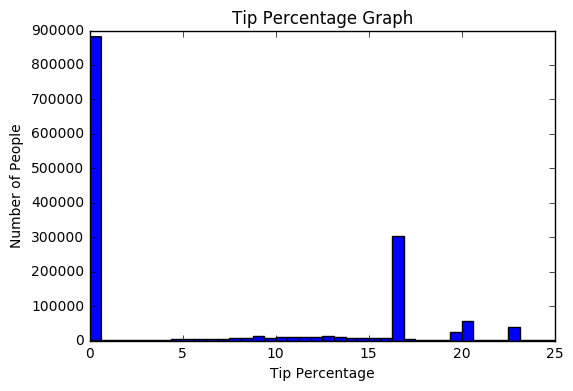

In [44]:
plt.hist(newdata['Tip_Percent'],bins = 40, range =(0,25))
plt.xlabel("Tip Percentage")
plt.ylabel("Number of People")
plt.title("Tip Percentage Graph")
plt.show()

#### Interpretation:
In most of the trips customers didn't pay any tip. However, 2nd most top tip percent is 16.6%. 
Also, It can also be concluded that 64% passengers don’t pay any tip.


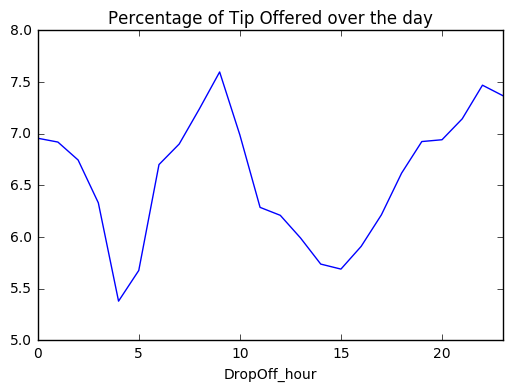

In [45]:
newdata.groupby('DropOff_hour').mean()['Tip_Percent'].plot(title="Percentage of Tip Offered over the day")

#### Interpretation:
Mornings and late evenings is when passengers prefer to give tip with an average tip of 7.5 % <br>

### MODEL: LINEAR REGRESSION

Considering our objective to predict the Tip Percentage amount, we can ignore following variables as they won't help in prediction and unnecessary make the model complex. The decision has been made having understand the business requirement.

* lpep_pickup_datetime
* Lpep_dropoff_datetime
* pickup_longitude
* Pickup_latitude
* Dropoff_longitude
* Dropoff_latitude
* LaGuadia_Pickup_Distance
* LaGuadia_DropOff_Distance
* LongIsland_Pickup_Distance
* LongIsland_DropOff_Distance
* JFK_Pickup_Distance
* JFK_DropOff_Distance


In [46]:
linear_model_cols = ['Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra',  'MTA_tax', 'Tolls_amount', \
                     'improvement_surcharge', 'Payment_type', 'Trip_type ', 'Trip_Time' , 'DropOff_hour' , 'PickUp_hour']
model_data = newdata[linear_model_cols].copy()
y=newdata['Tip_Percent']

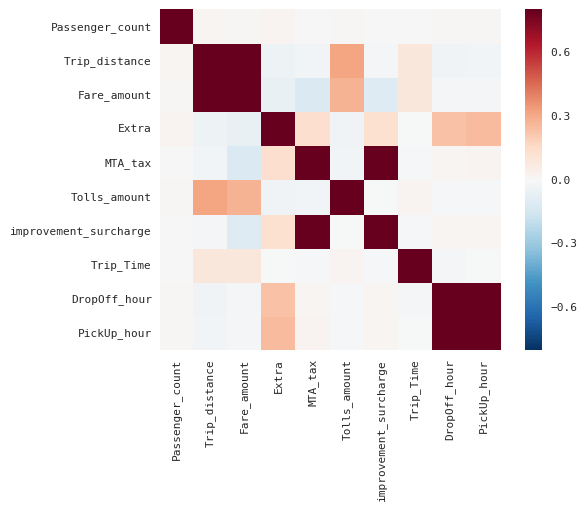

In [47]:
import seaborn as sns
sns.set(context="paper", font="monospace")
corrmat = model_data.corr()
f, ax = plt.subplots()
sns.heatmap(corrmat, vmax=.8, square=True)

In [48]:
corrmat

,Passenger_count,Trip_distance,Fare_amount,Extra,MTA_tax,Tolls_amount,improvement_surcharge,Trip_Time,DropOff_hour,PickUp_hour
Passenger_count,1.000000,0.013235,0.011930,0.019463,0.002141,0.008259,0.003002,0.004866,0.007948,0.009386
Trip_distance,0.013235,1.000000,0.870975,-0.040098,-0.027243,0.318509,-0.015482,0.089096,-0.035456,-0.029406
Fare_amount,0.011930,0.870975,1.000000,-0.061403,-0.122434,0.280821,-0.104534,0.092914,-0.018330,-0.015640
Extra,0.019463,-0.040098,-0.061403,1.000000,0.131991,-0.032844,0.130753,-0.003690,0.235510,0.254476
MTA_tax,0.002141,-0.027243,-0.122434,0.131991,1.000000,-0.030740,0.960207,-0.008804,0.017817,0.018906
Tolls_amount,0.008259,0.318509,0.280821,-0.032844,-0.030740,1.000000,-0.005729,0.023338,-0.006644,-0.008141
improvement_surcharge,0.003002,-0.015482,-0.104534,0.130753,0.960207,-0.005729,1.000000,-0.007432,0.017244,0.018078
Trip_Time,0.004866,0.089096,0.092914,-0.003690,-0.008804,0.023338,-0.007432,1.000000,-0.016655,-0.004138
DropOff_hour,0.007948,-0.035456,-0.018330,0.235510,0.017817,-0.006644,0.017244,-0.016655,1.000000,0.933734
PickUp_hour,0.009386,-0.029406,-0.015640,0.254476,0.018906,-0.008141,0.018078,-0.004138,0.933734,1.000000


<b>Interpretation:</b>
* Trip_distance and Fare_amount are highly correlated. This is because, if distance increases, fare_amount will increase. In other words, they are proportionaly related. Also, correlation coefficient is above our threshold limit of 0.85. Therefore, we'll remove one variable Trip_distance and keep Fare_amount.
* There seems to be strong relationship between MTA_tax and Improvement_surcharge as well. Strong positive relation signifies that MTA_tax increases with increase in improvement_surcharge. Also, the correlation coefficient is above our threshold limit of 0.85. Therefore, we'll remove improvement_surcharge and keep MTA_tax.

As per the correlation matrix, we have removed unnecessary variables and the revised correlation plot is as follows:

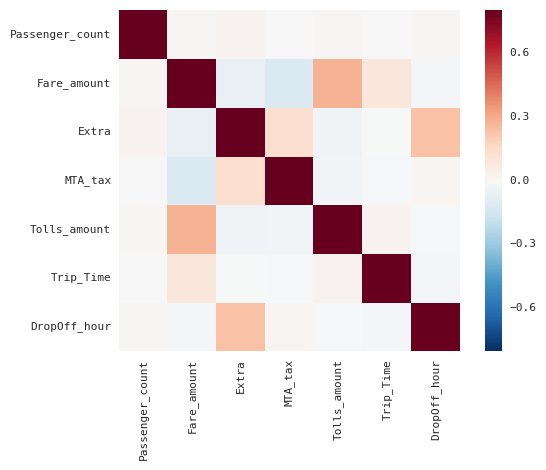

In [49]:
linear_model_cols = ['Passenger_count', 'Fare_amount', 'Extra',  'MTA_tax', 'Tolls_amount', \
                     'Payment_type', 'Trip_type ', 'Trip_Time' , 'DropOff_hour' ]
model_data = newdata[linear_model_cols].copy()
sns.set(context="paper", font="monospace")
corrmat = model_data.corr()
f, ax = plt.subplots()
sns.heatmap(corrmat, vmax=.8, square=True)

Following scatters plots are being build to understand if there is any linear relation between predictors and response variable as this is one of the important asssumption for linear models.

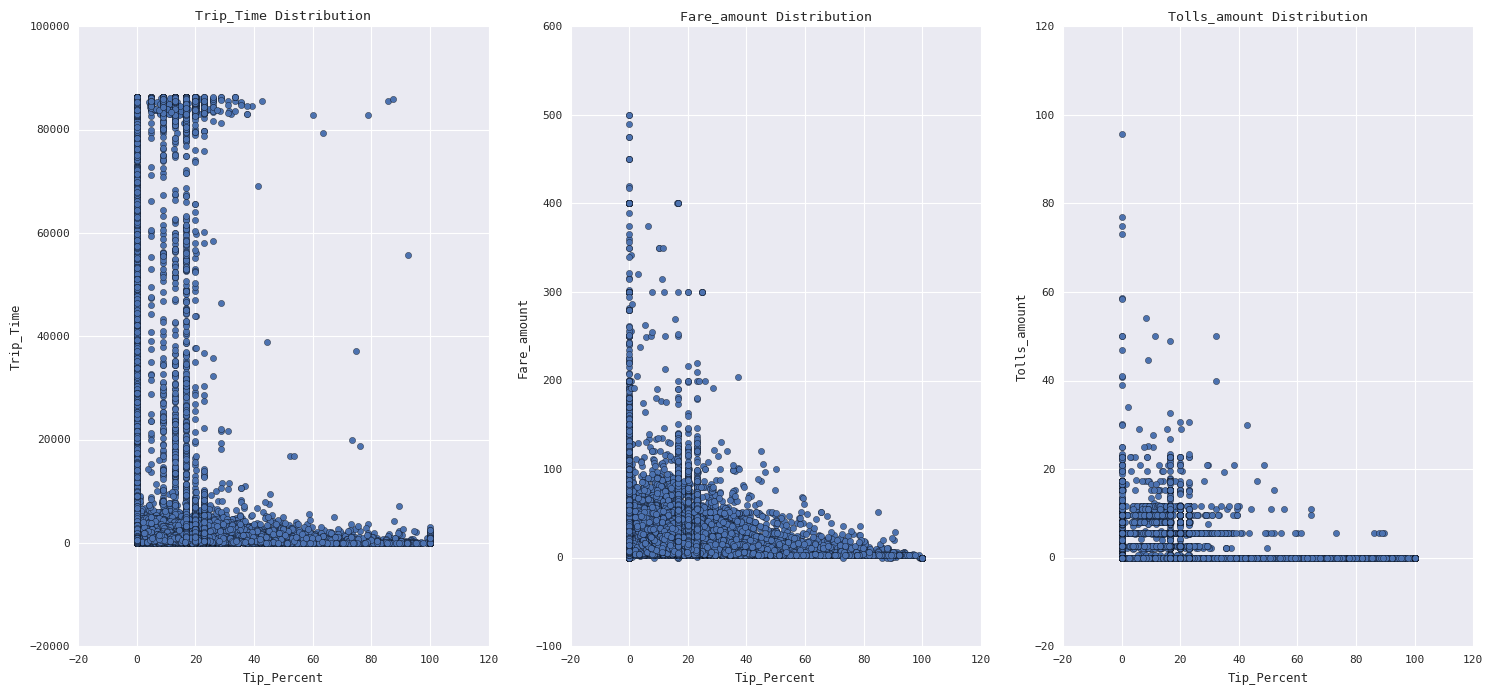

In [50]:
fig, axs = plt.subplots(1,3, figsize=(18,8))
fig.subplots_adjust(hspace=20)
newdata.plot(kind="scatter", x='Tip_Percent', y = 'Trip_Time', title="Trip_Time Distribution", ax=axs[0])
newdata.plot(kind="scatter", x='Tip_Percent', y = 'Fare_amount', title="Fare_amount Distribution", ax=axs[1])
newdata.plot(kind="scatter", x='Tip_Percent', y = 'Tolls_amount', title="Tolls_amount Distribution", ax=axs[2])

#### Interpretation:

There isn't a good linear relationship between predictor and response variables. Transformations needs to be performed to make it look more linear, which will increase predictive capabililities of linear model. <br>

Also, most of the records here have Tip_Percent as 0, which is a serious concern here.

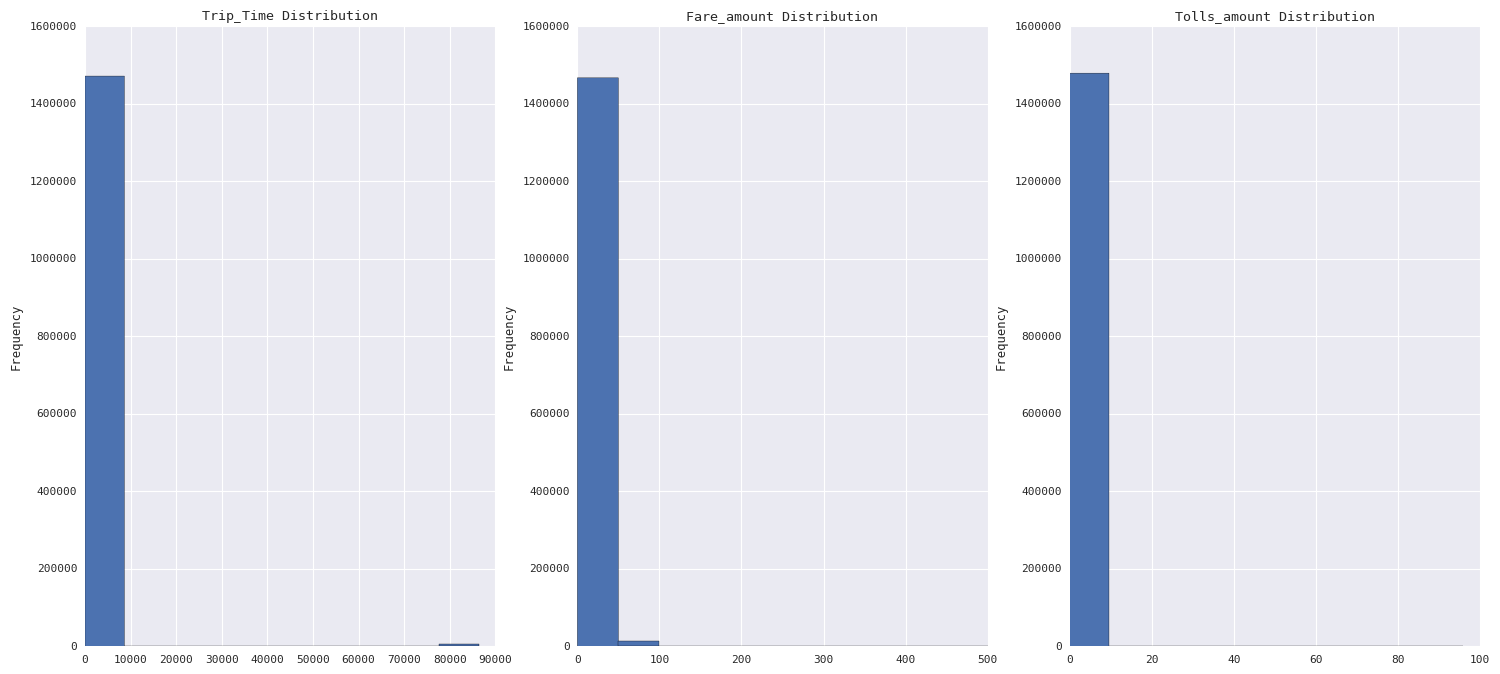

In [51]:
fig, axs = plt.subplots(1,3, figsize=(18,8))
fig.subplots_adjust(hspace=20)
model_data['Trip_Time'].plot(kind="hist", title="Trip_Time Distribution", ax=axs[0])
model_data['Fare_amount'].plot(kind="hist", title="Fare_amount Distribution", ax=axs[1])
model_data['Tolls_amount'].plot(kind="hist", title="Tolls_amount Distribution", ax=axs[2])

#### Interpretation:
The data is highly right skewed. This skewness will affect the linear model prediction capabilities. So, let's perform some transformations.

There are couple of normality test available to perform this.<br>
Shapiro test being the best one among all. However, it works best when N < 5000.<br>
In our case, Kolmogorov–Smirnov test would work great as N is 1.4 Million.

<b>Kolmogorov-Smirnov Test</b> performs a test of the distribution G(x) of an observed random variable against a given distribution F(x). Under the null hypothesis the two distributions are identical, G(x)=F(x).

If p-value is less than 5% or 0.05, then we reject the null hypothesis and conclude that distribution is not normal.

In [56]:
stats.kstest(model_data['Fare_amount'],'norm', N=len(model_data))

KstestResult(statistic=0.99325127187340756, pvalue=0.0)

In [57]:
stats.kstest(np.log10(model_data['Fare_amount']),'norm', N=len(model_data))

KstestResult(statistic=0.70115706691464574, pvalue=0.0)

<b> Note:  </b>
Without log10 transformation, KS Statistic is 0.65 and after log10 transformation, KS Statistic is 0.33
This signifies that distribution is somewhat more close to normal distribution.

In [59]:
from scipy.stats import skew
cols = ['Fare_amount', 'Extra', 'MTA_tax', 'Tolls_amount' ,'Trip_Time']

properties = pd.DataFrame({'ColName':[],'KS_Statistic':[], 'P-Value':[], 'After_Transform_KS':[], 'Before_Skewness':[], 'After_Skewness':[]})
for index, col in enumerate(cols):
    statistic = stats.kstest(newdata[col],'norm', N=len(newdata))
    properties.loc[index,'ColName']=col
    properties.loc[index,'KS_Statistic']=statistic[0]
    properties.loc[index,'P-Value']=statistic[1]
    transformed = stats.kstest(np.log10(newdata[col]+1),'norm', N=len(newdata))
    properties.loc[index,'After_Transform_KS'] = transformed[0]
    properties.loc[index,'Before_Skewness']=skew(newdata[col])
    properties.loc[index,'After_Skewness']=skew(np.log10(newdata[col]+1))
properties

,After_Skewness,After_Transform_KS,Before_Skewness,ColName,KS_Statistic,P-Value
0,0.511549,0.732439,5.303210,Fare_amount,0.993251,0.0
1,0.264460,0.499999,0.535739,Extra,0.499999,0.0
2,-6.909127,0.550171,-6.909127,MTA_tax,0.671745,0.0
3,6.826421,0.500000,11.397827,Tolls_amount,0.500000,0.0
4,-0.303990,0.956838,13.728251,Trip_Time,0.997730,0.0


All the continuous variables are transformed with log10. Generally, we should analyze each variable separately and find best possible transformation that leads to normality. Due to limited time, I am continuing with log10 as tranformation for all

<b>Note:</b> P-value is less than the 95% significance level threshold, which is 0.05.
Thus, for all of the variables we will reject the null hypothesis of variables being normal distributed. Despite performing transformation, they are not fully normally distribution

### BASELINE MODEL:
<b> Model with mean value as the predicted tip percent </b>

In [60]:
y = newdata['Tip_Percent']

In [61]:
from sklearn.model_selection import train_test_split
y_train, y_test = train_test_split(y, test_size = 0.2, random_state = 0)

In [62]:
basemodel = y_train.mean()
basemodel

6.655713740613843

In [63]:
base_pred = np.repeat(basemodel,len(y_test))

In [64]:
metrics.mean_squared_error(y_test,base_pred)

78.372450663840709

Using Baseline model of mean value, we get mean_squared_error of 78.37

### Approach 1: Predict Tip Amount in Numerics

#### MODEL: LINEAR REGRESSION

* Linear Model has an <b>assumption</b> that there should be no outlier. In the beginning itself, we have taken care of it and removed all the possible outliers out of it.
* Secondly, it assumes that its residuals have normal distribution. This assumption is very important and should not be violated. To do so, we'll be performing Q-Q Plot.
* Thirdly, linear models assumes that there should be no multicollinearity between the predictor variables. To do so, we have removed all such variables which have more than 0.85 correlation coefficient. Variance Inflation Factor could also be used here to remove multicollinearity when VIF > 10.
* Fourthly, we assume that there exists linear relationship between predictors and response variables.
* Lastly, linear model assumes that there is no auto-correlation between variables. In our cases, each ride and it's fare is independent, and has no correlation with past rides.

In [65]:
model_data.columns

Index([u'Passenger_count', u'Fare_amount', u'Extra', u'MTA_tax',
       u'Tolls_amount', u'Payment_type', u'Trip_type ', u'Trip_Time',
       u'DropOff_hour'],
      dtype='object')

In [67]:
cols = ['Extra', 'Tolls_amount', 'MTA_tax','Trip_Time', 'Fare_amount']

for col in cols:
    model_data[col]=np.log10(model_data[col]+1)

In [68]:
model_data = model_data.join(pd.get_dummies(model_data['Payment_type'], prefix='payment_type'))

In [69]:
model_data = model_data.join(pd.get_dummies(model_data['Trip_type '], prefix='trip_type'))

In [70]:
del model_data['Trip_type ']
del model_data['Payment_type']

Removing correlated and unnecessary variables:

In [176]:
y=newdata['Tip_Percent']

In [177]:
X_train, X_test, y_train, y_test = train_test_split(model_data, y, test_size = 0.2, random_state = 0)

In [178]:
from sklearn.feature_selection import RFE
lr = linear_model.LinearRegression()
selector = RFE(lr, 12, step=1)
selector = selector.fit(X_train, y_train)

Following are the set of variables that are used to create a linear regression model

In [179]:
important_columns = list(X_train.columns[selector.support_])
important_columns

['Fare_amount',
 'Extra',
 'MTA_tax',
 'Tolls_amount',
 'Trip_Time',
 'payment_type_1',
 'payment_type_2',
 'payment_type_3',
 'payment_type_4',
 'payment_type_5',
 'trip_type_1.0',
 'trip_type_2.0']

In [75]:
from sklearn.model_selection import cross_val_score
def cross_val_mse(model,x,y):
    scores = -cross_val_score(model, x, y, cv = 5, scoring='neg_mean_squared_error')
    return scores

In [180]:
lr = linear_model.LinearRegression()
print cross_val_mse(lr, X_train[important_columns], y_train)

[ 27.45006257  28.49322708  27.96943604  27.47331479  27.44580556]


Cross Validation Results:

* Without log tranformation, the model gives mean MSE of 35
* After making log transformation, we observe mean mean MSE of 27.45 <br>

In [181]:
lr.fit(X_train[important_columns],y_train)
predictions_train = lr.predict(X_train[important_columns])
metrics.r2_score(y_train,predictions_train)

0.6429292403812783

Analyzing Coefficient of Determination (R2) which gives explains the amount of variance in the response variable.
Here, we are considering Adjusted R2 as it considers the effect of extra and irrelevant variables in the model.

* Without log transformation, R2-Squared value was roughly 56%
* After making log transformation, R2-Squared value has increased to 64% <br>

<b>Conclusion:</b> Log10 Transformation has significantly improved the results.

In [182]:
predictions_test = lr.predict(X_test[important_columns])
metrics.mean_squared_error(y_test, predictions_test)

28.110235686052309

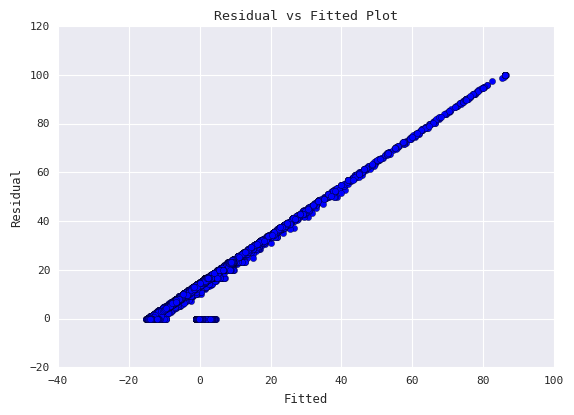

In [80]:
residuals = y_test - predictions_test
plt.scatter(residuals,y_test)
plt.xlabel("Fitted")
plt.ylabel("Residual")
plt.title("Residual vs Fitted Plot")
plt.show()

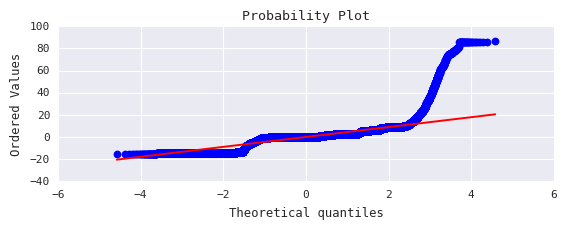

In [81]:
from scipy import stats
fig = plt.figure()
ax1 = fig.add_subplot(211)
stats.probplot(residuals, dist="norm", plot=ax1)
plt.show()

### Interpretation:

Probability plot is not normal. There is certainly a trend in the residual vs fitted plot. <br>
To remove this, we need to perform some transformations on the response variables. <br>
We'll use BoxCox to know which transformation would be best for response variable.

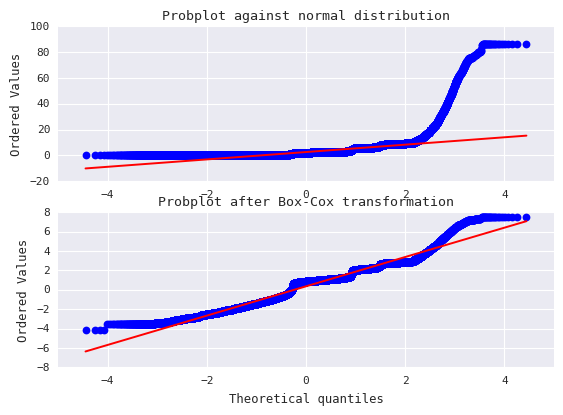

In [82]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
prob = stats.probplot(residuals[residuals>0], dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')
ax2 = fig.add_subplot(212)
residuals_T, transformation = stats.boxcox(residuals[residuals>0])
prob = stats.probplot(residuals_T, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
plt.show()

In [137]:
print transformation

0.21825310811


<b>Conclusion:</b> From <b>BoxCox Transformation table</b>, we find that for lambda value of 0.21825. we need to perform natural log.

In [183]:
y=np.log(newdata['Tip_Percent']+1)
X_train, X_test, y_train, y_test = train_test_split(model_data, y, test_size = 0.2, random_state = 0)
lr = linear_model.LinearRegression()
print cross_val_mse(lr, X_train[important_columns], y_train)

[ 0.49278422  0.49416244  0.49143974  0.48557001  0.49043181]


In [184]:
lr.fit(X_train[important_columns],y_train)
predictions_train = lr.predict(X_train[important_columns])
metrics.r2_score(y_train,predictions_train)

0.74801161032798236

In [185]:
print "Linear Model Equation:"
print str(lr.intercept_) ,
for i in range(0,len(important_columns)):
    coeff = str(round(lr.coef_[i],2))
    var = str(important_columns[i])
    print coeff + "*" + var,

Linear Model Equation:
267357764761.0 -0.14*Fare_amount -0.01*Extra 1.32*MTA_tax 0.26*Tolls_amount 0.77*Trip_Time -2.69601519413e+11*payment_type_1 -2.69601519415e+11*payment_type_2 -2.69601519415e+11*payment_type_3 -2.69601519415e+11*payment_type_4 -2.69601519415e+11*payment_type_5 2243754653.25*trip_type_1.0 2243754652.97*trip_type_2.0


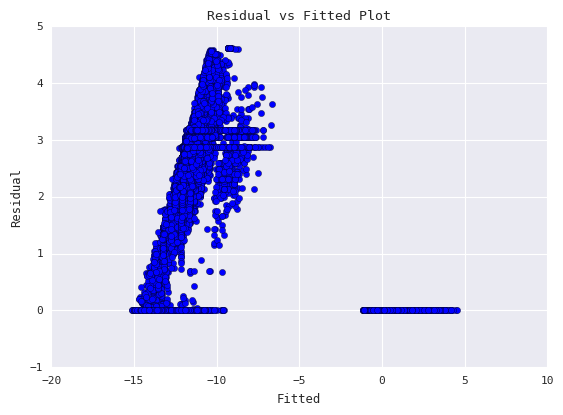

In [93]:
residuals = y_test - predictions_test
plt.scatter(residuals,y_test)
plt.xlabel("Fitted")
plt.ylabel("Residual")
plt.title("Residual vs Fitted Plot")
plt.show()

### Interpretation: 

Lot of linearity in the residual vs fitted plot is because of the constant and significant number of zero values in the Tip_Percent column. However, after taking log transformation of the response variable, there is significant improvement.

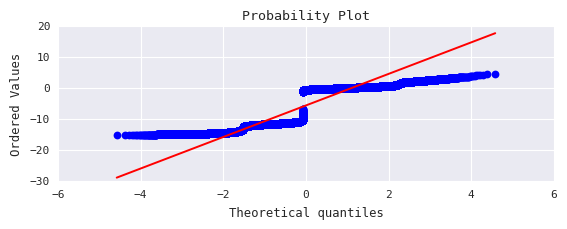

In [94]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
stats.probplot(residuals, dist="norm", plot=ax1)
plt.show()

### Final Conclusion:
We observed that after performing <b>Natural Log transformation</b> on Response variable. Our R2-Squared value has increased from 63% to 75%, which is a significant improvement. <br>

Also, the residual vs fitted plot is still nor normal but better than previous. Not an ideal one anyway. <br>

There is scope of improvement with transformation like log1p, exponentials, sqrt, inverse etc. <br>

There is non-linearity in the predictor variables as well, which suggests us to move ahead with non-linear model such as Random Forest Regressor.

    

### Model: Random Forest Regressor

In [98]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
rf_model_data = newdata.copy()
le.fit(rf_model_data['Store_and_fwd_flag'])
encoded_Store_fwd = le.transform(rf_model_data['Store_and_fwd_flag'])
rf_model_data['Encoded_Store_Fwd'] = encoded_Store_fwd
rf_model_data['Encoded_Store_Fwd'] = rf_model_data['Encoded_Store_Fwd'].astype('category')

Unnecessary Variables and other variables such as Total_amount that are created from summation of other variables are removed.

In [99]:
y = rf_model_data['Tip_Percent']

del_cols = ['JFK_DropOff_Distance','Tip_Percent','Tip_amount', 'Total_amount', 'Speed', 'JFK_Pickup_Distance', \
           'LaGuadia_Pickup_Distance', 'LaGuadia_DropOff_Distance', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime', 'Store_and_fwd_flag']

for col in del_cols:
    del rf_model_data[col]

In [100]:
X_train, X_test, y_train, y_test = train_test_split(rf_model_data, y, test_size = 0.2, random_state = 0)

In [101]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=0, n_estimators=10)
print cross_val_mse(rf, X_train, y_train)

[ 25.76039395  26.21744564  25.75291971  25.41975479  25.52329825]


In [102]:
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)

In [103]:
metrics.mean_squared_error(y_test,rf_pred)

25.644181255567336

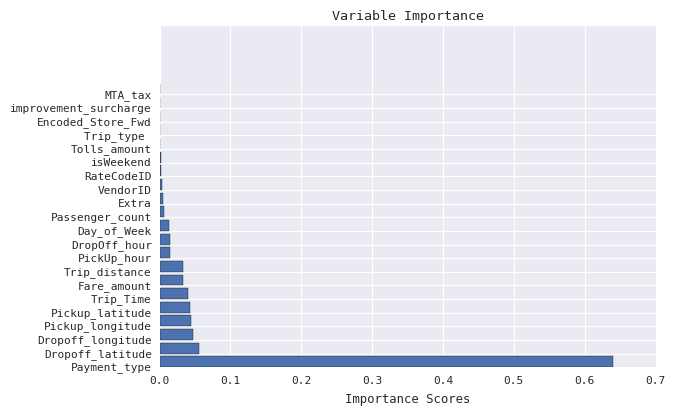

In [104]:
importance = rf.feature_importances_
names = X_train.columns
importance_list = sorted(zip(map(lambda x: round(x, 4),importance), names), reverse=True)
scores = [s[0] for s in importance_list]
var_names = [v[1] for v in importance_list]
y_pos = np.arange(len(var_names))
plt.barh(y_pos, scores)
plt.yticks(y_pos, var_names)
plt.title("Variable Importance")
plt.xlabel("Importance Scores")
plt.show()

Certainly the model does better than naive Linear Model. It is because there is some non-linearity in the dataset and this is handled by Random Forest better than the linear models.<br>
Also, ensembling multiple decision tree is giving much better results in the end.

* Payment_type is the most important variable among all. This can be justified with the fact that people prefer paying Tip using Credit Card rather than Cash. 
* Latitude and Longitude has given significant information, in predicting tip amoung.


### Approach 2: Predict Tip Amount Bin 
<b> Rather than calculating exact Tip amount, it would also be useful to know in what bin the Tip would lie based on the ride information. </b>

In [106]:
multi_model_data = newdata.copy()

def tip_bin_creator(x):
    if x >=0 and x<10:
        return "Bin1"
    if x >=10 and x<20:
        return "Bin2"
    if x>=20 and x<30:
        return "Bin3"
    if x>=30:
        return "Bin4"
    
multi_model_data['Tip_Bins']=multi_model_data.apply(lambda x: tip_bin_creator(x['Tip_Percent']), axis=1)        

del_cols = ['Tip_Bins', 'Tip_Percent', 'LaGuadia_Pickup_Distance', 'LaGuadia_DropOff_Distance', \
            'JFK_Pickup_Distance', 'JFK_DropOff_Distance', 'Store_and_fwd_flag', 'lpep_pickup_datetime', \
           'Lpep_dropoff_datetime', 'Tip_amount', 'Pickup_longitude', 'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude']
y = multi_model_data['Tip_Bins']

for col in del_cols:
    del multi_model_data[col]

In [107]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=25, n_jobs=-1, min_samples_split=5, max_depth=35)
X_train, X_test, y_train, y_test = train_test_split(multi_model_data, y, test_size = 0.2, random_state = 0)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=35, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=25, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [108]:
bin_pred =  rf.predict(X_test)

In [109]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(bin_pred, y_test, average=None, labels=['Bin1','Bin2','Bin3', 'Bin4'])

In [110]:
y_test.value_counts()

Bin1    188236
Bin2     85648
Bin3     20917
Bin4      1269
Name: Tip_Bins, dtype: int64

In [111]:
index = ['Bin1','Bin2','Bin3', 'Bin4']
performance = pd.DataFrame({'Precision': precision, 'Recall': recall, 'FScore': fscore, 'Support': support}, index = index)
performance

,FScore,Precision,Recall,Support
Bin1,0.994794,0.992339,0.997261,187307
Bin2,0.972970,0.993754,0.953038,89307
Bin3,0.919967,0.869102,0.977155,18604
Bin4,0.795851,0.665091,0.990610,852


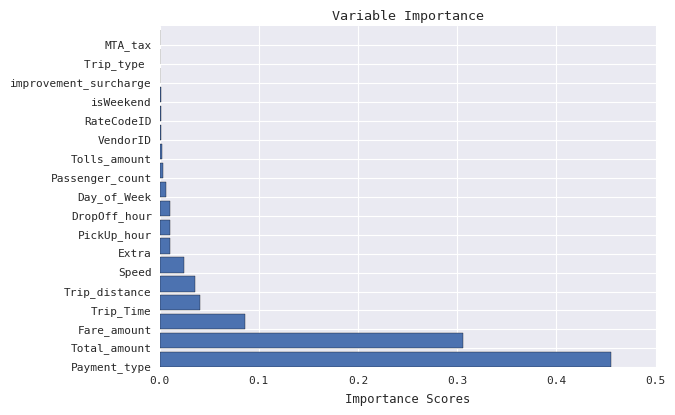

In [113]:
importance = rf.feature_importances_
names = X_train.columns
importance_list = sorted(zip(map(lambda x: round(x, 4),importance), names), reverse=True)
scores = [s[0] for s in importance_list]
var_names = [v[1] for v in importance_list]
y_pos = np.arange(len(var_names))
plt.barh(y_pos, scores)
plt.yticks(y_pos, var_names)
plt.title("Variable Importance")
plt.xlabel("Importance Scores")
plt.show()

Here again, we see Payment_type as the most significant variable. FScores for each of the bin are respectable.<br>
Considering these scores, we can conclude that it is possible to predict the bins more correctedly rather than predicting the exact tip amount.

# Question 5: Anamoly Detection

<b>
* What anomalies can you find in the data? Did taxi traffic or behavior deviate from the norm on a particular day/time or in a particular location?
* Using time-series analysis, clustering, or some other method, please develop a process/methodology to identify out of the norm behavior and attempt to explain why those anomalies occurred.
</b>

### Approach 1: 
As per the website http://www.nyc.gov/html/tlc/html/passenger/shl_passenger.shtml

* Fact 1: Boro Taxi drivers can pick up passengers from the street in northern Manhattan (north of West 110th street and East 96th street), the Bronx, Queens (excluding the airports), Brooklyn and Staten Island and they may drop you off anywhere. 

* Fact 2: Boro Taxi drivers can be dispatched to pick you up in northern Manhattan, the Bronx, Queens, Brooklyn and Staten Island and at the airports, but may not pick up any trips – pre-arranged or street hail – in the Manhattan exclusionary zone. 

According to this information, I have developed a geocoordinates polygon for each of the area in consideration. This includes:
* Brooklyn
* Bronx
* North_Manhattan
* South_Manhattan
* Staten Island
* Queens

In [114]:
def Coordinate_checker(lat,lon,boundary_coord):

    n = len(boundary_coord)
    inside = False

    point1_lat, point1_lon = boundary_coord[0]
    for i in range(n):
        point2_lat, point2_lon = boundary_coord[i]
        if (lon > min(point1_lon,point2_lon)) & (lon <= max(point1_lon,point2_lon)):
                if lat <= max(point1_lat,point2_lat):
                    if point1_lon != point2_lon:
                        latints = (lon-point1_lon)*(point2_lat-point1_lat)/(point2_lon-point1_lon)+point1_lat
                    if point1_lat == point2_lat or lat <= latints:
                        inside = not inside
        point1_lat,point1_lon = point2_lat,point2_lon

    return inside

Brooklyn_boundary = [(40.738811, -73.955657),(40.662015, -73.844713),(40.559811, -73.961477), (40.615548, -74.048772), (40.738811, -73.955657)]
Bronx_boundary = [(40.921136, -73.908234), (40.870270, -73.748932), (40.801696, -73.790131), (40.793372, -73.874090), ( 40.813800, -73.931063),(40.879581, -73.907074), (40.921136, -73.908234)] 
N_manhattan_boundary = [ (40.807426, -73.973162), (40.878229, -73.929814), (40.872270, -73.909125), (40.833520, -73.933755), ( 40.796985, -73.927844 ) , (40.781321, -73.939666), (40.807426, -73.973162) ]
S_manhattan_boundary = [ (40.797731, -73.979073), (40.779487, -73.938065), (40.710199, -73.977260), (40.700294, -74.022987), (40.797731, -73.979073) ]
Staten_boundary = [(40.646988, -74.185830), (40.650595, -74.070532), (40.600075, -74.049137), (40.488072, -74.255959), ( 40.646988, -74.185830 )]
Queen_boundary = [(40.538313, -73.942611), (40.591518, -73.737991), (40.754002, -73.699539), (40.807036, -73.776443), (40.793522, -73.913772), (40.736315, -73.964584), (40.628008, -73.835495),(40.538313, -73.942611)]
boundary_names = ["Brooklyn", "Bronx", "North_Manhattan","South_Manhattan","Staten Island", "Queens"]
search_boundary = [Brooklyn_boundary, Bronx_boundary, N_manhattan_boundary, S_manhattan_boundary, Staten_boundary, Queen_boundary]

def location_finder(lat,lon):
    for index, boundary in enumerate(search_boundary):
        found = Coordinate_checker(lat,lon,boundary)
        if found == True:
            return boundary_names[index]
        if index == 5 and found == False:
            return "Outlier"

newdata['Pickup_Location']=newdata.apply(lambda x: location_finder(x['Pickup_latitude'],x['Pickup_longitude']), axis=1)
newdata['Dropoff_Location']=newdata.apply(lambda x: location_finder(x['Dropoff_latitude'],x['Dropoff_longitude']), axis=1)

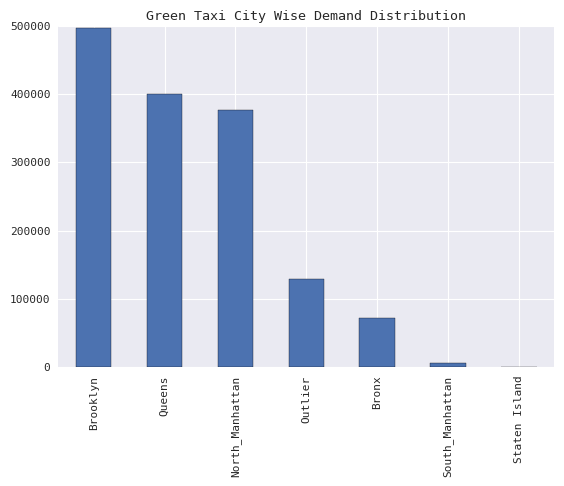

In [120]:
newdata.Pickup_Location.value_counts().plot(kind='bar', title="Green Taxi City Wise Demand Distribution")

#### Interpretation: 
South_Manhattan areas would be the restricted ones and NYC police department can impose fine on those taxi drivers.
Other than this, there are significant number of Outlier, which possible means went out of NYC city or out of these boroughs.

Number of taxis went out of authorized areas: 128433 <br>
Number of Taxis that did pick up from Restricted Manhattan area is 5486

In [116]:
outlier_pick = newdata[newdata['Pickup_Location']=='Outlier']
outlier_pick_count = outlier_pick.groupby('PickUp_hour').agg('count')
outlier_drop = newdata[newdata['Dropoff_Location']=='Outlier']
outlier_drop_count = outlier_drop.groupby('DropOff_hour').agg('count')

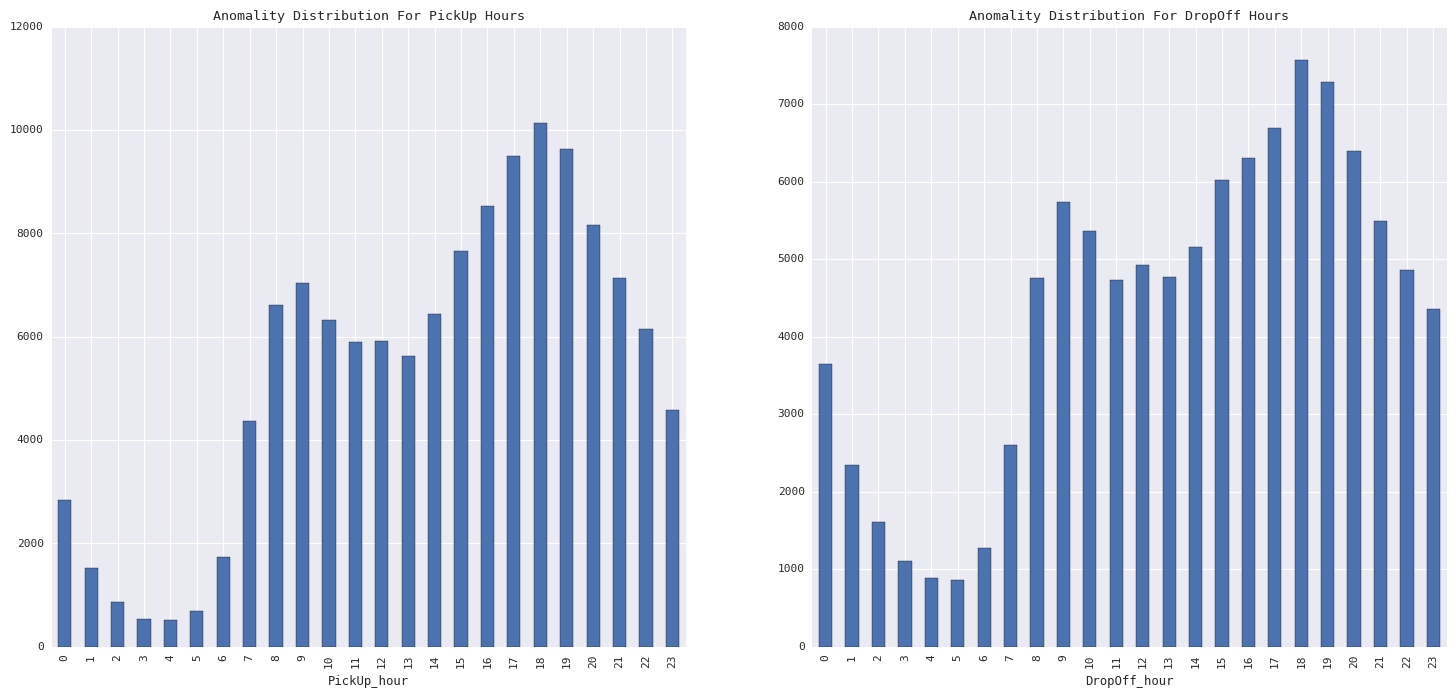

In [117]:
fig, axs = plt.subplots(1,2, figsize=(18,8))
fig.subplots_adjust(hspace=20)
outlier_pick_count['Pickup_Location'].plot(kind="bar", title="Anomality Distribution For PickUp Hours", ax=axs[0])
outlier_drop_count['Dropoff_Location'].plot(kind="bar", title="Anomality Distribution For DropOff Hours", ax=axs[1])

#### Interpretation:

If you observe it carefully the overall distribution is very similar. This can be justified with the situation where passenger hailed the taxi in one of boroughs and took it over to a place where Green Taxi's generally don't operate like New Jersey.
It is understood, that driver would again look for a passenger who wants to go one of those boroughs.

Thus, Outlier at a DropOff Hour is followed by Outlier at Pickup hour.

In [118]:
Location_Time = newdata.groupby(['Day_of_Week', 'PickUp_hour', 'Pickup_Location']).agg('count')

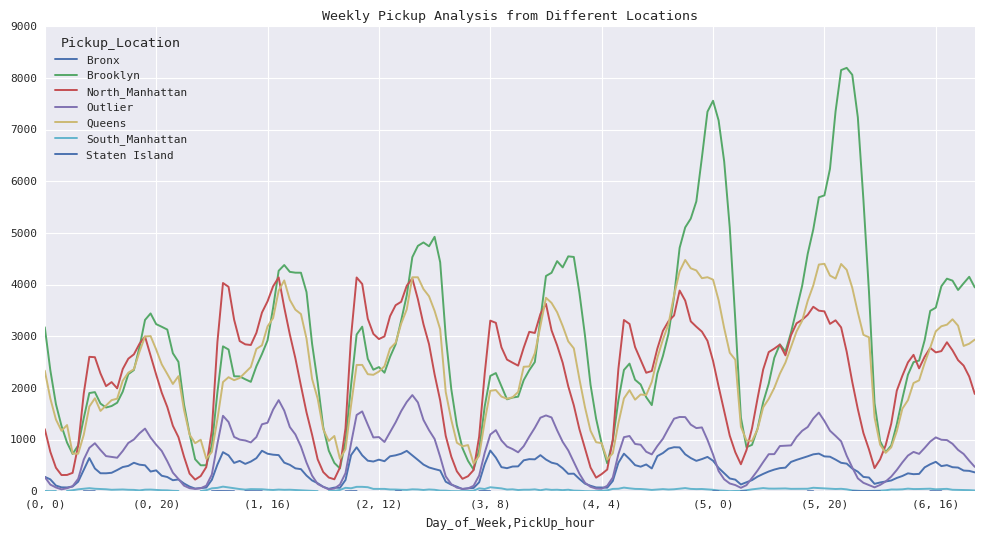

In [119]:
fig, axs = plt.subplots(figsize=(12,6))
Location_Time['lpep_pickup_datetime'].unstack('Pickup_Location').plot(ax=axs, title="Weekly Pickup Analysis from Different Locations")

In the above figure, Day_of_week is classified as 0 being Monday and 6 being Sunday.

#### Interpretation: 
* From the above graph we can conclude that on Friday's and Saturday's there is a sudden surge in demand for Green Taxis in Brooklyn area. 
* Demand from Queens and North Manhattan types area follows relatively same pattern through out week.

### Approach 2: Anomaly detection using DBSCAN Clustering

DBSCAN is a density based clustering algorithm which can help us identify anomaly. Well known K-means clustering algorithm cannot be used here as we are primarily dealing with Geo-coordinates to form clusters. K-means uses only Euclidean distance which is not correct when dealing with geo-coordinates. <br>

DBSCAN clustering Algorithm allows us to use Haversine Distance to calculate miles distance between two geo-points and hence, this is the right choice. <br>

Epsilon(eps) metric specifies how close points should be to each other to be considered a part of a cluster.<br>

DBSCAN is a CPU intensive algorithm and it is not possible to run it on a 8GB RAM with i5 Intel processor. <br>

However, I was able to form cluster for random 30000 data points and could observe 5 outliers.<br>

Unfortunately, Jupyter Notebook is facing some plotting issues and couldn't present straight way here.
I have included a snapshot of the cluster formation done in Spyder software. <br>

Please take a look for the DBSCAN_Clustering.png file.

## Area of Improvement / Further Work:
* To detect Anomaly, we can try - one-class-SVM model and even unsupervised Random Forest which uses promixity values to find anamolous records
* To predict Tip Fare, I could have created a feature that would take into account the population density. For this, we can create NxN matrix and use geo-coordinates to give us rough estimate of population density.
* To predict Tip Fare, external data saying something about the age of the passenger could also help in predicting tip price. This is because, old people are more generous as compared to young professionals.
* We can checkout results given by Gradient Boosting Machine like AdaBoost.
* At Last, lot of further exploration and insights could be provided if we could join some external dataset like weather, driver information etc.
